In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


import random

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# data processing

In [3]:
df = pd.read_csv("data/my_horizon_data_all.csv", dtype={"subject": str})
df.head()

,subject,block,m1,m2,uc,gameLength,age,gender,trial,reward,...,rt0,rt1,rt2,rt3,rt4,rt5,rt6,rt7,rt8,rt9
0,0,0,40,36,1,6,18,-99,0,42,...,184.143661,4.635614,1.122532,2.833540,2.738855,5.263696,5.763985,1.940346,0.937745,2.472841
1,0,1,60,48,0,6,18,-99,0,67,...,1.184903,1.013671,1.305989,8.874533,2.708196,2.426142,1.115581,1.370487,1.103393,1.046302
2,0,2,40,36,0,6,18,-99,0,37,...,0.832413,0.468084,0.566725,0.445963,1.810017,1.325654,0.892086,0.780645,1.881181,0.576540
3,0,3,40,48,0,1,18,-99,0,58,...,0.830383,0.553779,0.817720,1.686227,0.910277,NaN,NaN,NaN,NaN,NaN
4,0,4,40,10,0,1,18,-99,0,4,...,0.663673,1.049479,0.692706,3.581879,4.616839,NaN,NaN,NaN,NaN,NaN


In [4]:


seq_features = [
    'r0', 'c0',
    'r1', 'c1',
    'r2', 'c2',
    'r3', 'c3',
]
static_features = ['gameLength', 'uc']

target = 'c4'

X_seq = df[seq_features]
X_static = df[static_features]
y = df[target]

print(type(X_seq))
X_seq_train, X_seq_test, X_static_train, X_static_test, y_train, y_test = train_test_split(X_seq, X_static, y, test_size=0.2, random_state=42)
print(type(X_seq_train))

# split based on original data frame
h1_mask = X_static_test['gameLength'] == 1
h6_mask = X_static_test['gameLength'] == 6
X_static_test_raw = X_static_test.copy()

scaler = StandardScaler()
X_seq_train = scaler.fit_transform(X_seq_train)
X_seq_test = scaler.transform(X_seq_test)
X_static_train = scaler.fit_transform(X_static_train)
X_static_test = scaler.transform(X_static_test)


<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [5]:
SEQ_LEN = len(seq_features) // 4 
print(f"SEQ_LEN: {SEQ_LEN}")

SEQ_LEN: 2


In [6]:
# reshape to (num_samples, time_steps, features)
X_seq_train = X_seq_train.reshape(-1, 4, SEQ_LEN)
X_seq_test = X_seq_test.reshape(-1, 4, SEQ_LEN)

convert to tensor for pytorch

In [7]:

X_seq_train_tensor = torch.tensor(X_seq_train, dtype=torch.float32) # sklearn output float64, doesn't work with torch
X_seq_test_tensor = torch.tensor(X_seq_test, dtype=torch.float32) 

X_static_train_tensor = torch.tensor(X_static_train, dtype=torch.float32) 
X_static_test_tensor = torch.tensor(X_static_test, dtype=torch.float32) 

y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long) # pandas series to tensor
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [8]:
train_loader = DataLoader(TensorDataset(X_seq_train_tensor, X_static_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_seq_test_tensor, X_static_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

In [9]:
# get the scaled tensor for h1 h6
# convert pandas series -> numpy array -> torch BoolTensor
h1_mask_bool = torch.tensor(h1_mask.to_numpy(), dtype=torch.bool)
h6_mask_bool = torch.tensor(h6_mask.to_numpy(), dtype=torch.bool)

X_seq_test_h1 = torch.tensor(X_seq_test[h1_mask_bool], dtype=torch.float32)
X_seq_test_h6 = torch.tensor(X_seq_test[h6_mask_bool], dtype=torch.float32)

X_static_test_h1 = torch.tensor(X_static_test[h1_mask_bool], dtype=torch.float32)
X_static_test_h6 = torch.tensor(X_static_test[h6_mask_bool], dtype=torch.float32)

y_test_h1 = y_test_tensor[h1_mask_bool]
y_test_h6 = y_test_tensor[h6_mask_bool]


In [10]:
print(type(X_seq_test_h1))
print(type(X_static_test_h1))
print(type(y_test_h1))

<class 'torch.Tensor'>
<class 'torch.Tensor'>
<class 'torch.Tensor'>


In [11]:

test_loader_h1 = DataLoader(TensorDataset(X_seq_test_h1, X_static_test_h1, y_test_h1), batch_size=32, shuffle=False)
test_loader_h6 = DataLoader(TensorDataset(X_seq_test_h6, X_static_test_h6, y_test_h6), batch_size=32, shuffle=False)

# running experiment

In [12]:
from utils.models import (
    RNN,
    LSTM,
    GRU,
    TinyGRU,
    TransformerEncoderPositionalEncoding,
    SelfAttentionOnly,
)
from utils.train_eval import train_and_evaluate

In [13]:
SEQ_LEN

2

In [14]:
model_dict = {
    "RNN": RNN(SEQ_LEN).to(device),
    "LSTM": LSTM(SEQ_LEN).to(device),
    "GRU": GRU(SEQ_LEN).to(device),
    "TinyGRU": TinyGRU(SEQ_LEN).to(device),
    "Transformer": TransformerEncoderPositionalEncoding(SEQ_LEN).to(device),
    "Self-Attention": SelfAttentionOnly(SEQ_LEN).to(device),
    # "TinyAttentionNoProj": TinyAttentionNoProj(SEQ_LEN).to(device),
}

In [ ]:
epochs = 100
test_loaders = (test_loader, test_loader_h1, test_loader_h6)
for model_name, model in model_dict.items():
    print(f"\nTraining model: {model_name}")
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    history = train_and_evaluate(model, train_loader, test_loaders, criterion, optimizer, device, epochs=epochs)
    model_dict[model_name] = {
        "model": model,
        **history
    }



Training model: RNN
Epoch 1: Loss: 0.5045 | overall: 0.7757 | H1 0.8124 | H6 0.7390
Epoch 10: Loss: 0.4954 | overall: 0.7758 | H1 0.8136 | H6 0.7382
Epoch 20: Loss: 0.4961 | overall: 0.7752 | H1 0.8139 | H6 0.7366
Early stopping triggered: epoch 21 best_loss 0.4954

Training model: LSTM
Epoch 1: Loss: 0.5067 | overall: 0.7759 | H1 0.8139 | H6 0.7380
Epoch 10: Loss: 0.4928 | overall: 0.7786 | H1 0.8153 | H6 0.7421
Epoch 20: Loss: 0.4923 | overall: 0.7777 | H1 0.8160 | H6 0.7396
Early stopping triggered: epoch 25 best_loss 0.4916

Training model: GRU
Epoch 1: Loss: 0.5024 | overall: 0.7729 | H1 0.8069 | H6 0.7390
Epoch 10: Loss: 0.4953 | overall: 0.7782 | H1 0.8154 | H6 0.7410
Early stopping triggered: epoch 14 best_loss 0.4919

Training model: TinyGRU
Epoch 1: Loss: 0.5274 | overall: 0.7630 | H1 0.7912 | H6 0.7350
Epoch 10: Loss: 0.5177 | overall: 0.7669 | H1 0.7993 | H6 0.7346
Epoch 20: Loss: 0.5153 | overall: 0.7708 | H1 0.8054 | H6 0.7363
Epoch 30: Loss: 0.5137 | overall: 0.7690 | H

TypeError: Object of type RNN is not JSON serializable

In [17]:
dump_history = {}

for model_name, content in model_dict.items():
    # content = {"model": <model_object>, "train_acc": ..., "test_acc": ..., ...}
    filtered = {k: v for k, v in content.items() if k != "model"}
    dump_history[model_name] = filtered
# store the outputs 
import json
with open("output_all_models.json", "w") as f:
    json.dump(dump_history, f)

# plotting

In [43]:
import importlib
import utils.plotting as plotting
importlib.reload(plotting)

<module 'utils.plotting' from 'c:\\Users\\91486\\Documents\\GT\\CoCo\\Horizon\\utils\\plotting.py'>

In [44]:
from utils.plotting import plot_test_loss, plot_error_bars

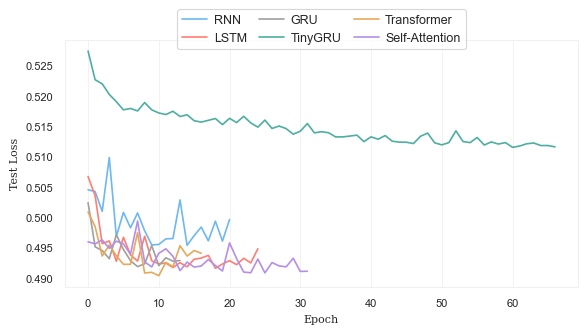

In [45]:
plot_test_loss(model_dict)

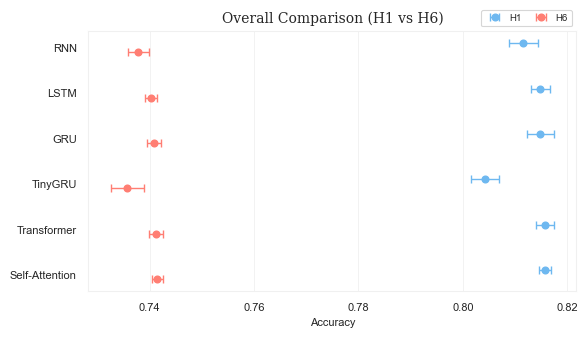

In [49]:
plot_error_bars(model_dict, title="Overall Comparison (H1 vs H6)")